In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
!python -m pip install --upgrade pip
!python -m pip install keras-tuner

     |████████████████████████████████| 1.5 MB 4.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
     |████████████████████████████████| 54 kB 1.3 MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=9a45f31c929d6de4e42caca6051f2492e8f777f1f84c73c0e96cf56fdeb110f0
  Stored in directory: /root/.cache/pip/wheels/0b/cf/2f/1a1749d3a3650fac3305a8d7f9237b6de7c41068e2f8520ca2
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=fec4263c3ed9975c0132c49252ff43e5fd8635cc263a53c40123aa598d7b57b5
  Stored in directory: /root/.cache/pip/wheels/ba/ad/c8/2d98360791161cd3db6daf6b5e730f34021fc9367d5879f497
Successfully built keras-tuner terminaltables


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# To display all the columns from left to right without breaking into next line.
pd.set_option("display.width", 1500)
pd.plotting.register_matplotlib_converters()

import matplotlib.pyplot as plt
%matplotlib inline
# notebook

import seaborn as sns

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


In [4]:
# Define seed to reprodicibility of random generation
SEED = 42

DEV_SPLIT=0.2

# MODE = "DEV"
MODE = "EVAL"

In [5]:
import random as python_random

# Make sure Keras produces reproducible results.

np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)
for device in (physical_devices or []):
    tf.config.experimental.set_memory_growth(device, True)

[]


# Read data and extract usable features

In [7]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col="PassengerId")

In [8]:
features = "Pclass Sex SibSp Parch Fare Embarked Name Cabin Age".split()

X_train_init = train_data[features]
Y_train_init = train_data.Survived

print(X_train_init.shape)
print(Y_train_init.shape)

X_test_init = test_data[features]

print(X_test_init.shape)

(891, 9)
(891,)
(418, 9)


# Split into train/dev sets
## Needs to be done before pre-processing to avoid test-train contamination

In [9]:
from sklearn.model_selection import train_test_split

# if MODE == "DEV":
X_train_unproc, X_dev_unproc, Y_train_unproc, Y_dev_unproc = train_test_split(X_train_init, Y_train_init, test_size=DEV_SPLIT, random_state=SEED)

print(X_train_unproc.shape, Y_train_unproc.shape)
print(X_dev_unproc.shape, Y_dev_unproc.shape)

(712, 9) (712,)
(179, 9) (179,)


## Data observations
*Have NaNs:* Age, Fare (some zeros, nans too), Cabin, Embarked
*NOTE:* maybe need to approximate missing values using some other technique, like an additional model?

* (+) Pclass:
  * 1 - 3 number, 1 being the highest
  * Range: 1-3
  * Current approach: convert to one-hot.
  * Previous approaches:
      * normalize by 3.
* (+) Name:
  * has person's title, which could be used (Mr, Ms, Mrs, etc.)
  * From title, can infer marital status?
  * Current approach: extract titles, replace infrequent ones with "Others", convert them to one-hot, and calculate 'Married' based on title (1 - married (Mr, Mrs), -1 - unmarried (Miss, Master), 0 - unknown (other titles))
  * Potential improvements: use more titles for getting 'married'; use 'maiden name' in calculation of 'married'; use 'nickname' somehow?
* (+) Sex:
  * Either male or female
  * male: 65%, female: 35%
  * Current approach: convert to one-hot.
  * Potential improvements: use 1 and -1 for sexes?
* (+) Age:
  * has fractions if approximated. Has missing values.
  * Range: 0.42-80
  * Current approach: fill NaN with average in group-by Pclass-Sex, but create a column that identifies missing values. Also, normalize by 80.
  * Potential improvements: have a better approximation of age. Convert to age categories?
* (+) SibSp:
  * how many siblings or spouses on board.
  * Range: 0-8
  * Current approach: Add to 'Family'.
  * Previous approaches:
    * normalize by 8.
* (+) Parch:
  * How many parents/children. (can be 0 for babies, if with nannies)
  * Range: 0-6
  * Current approach: Add to 'Family'
  * Previous approachesL
    * normalize by 6.
* Ticket:
  * A number with some optional letters (which can have some meaning?).
  * Has repetitions (maybe for people travelling together).
* (+) Fare:
  * can have zeros (what do they mean?). Can have omitted (just one in test).
  * Range: 0-512.3292
  * Current approach: fill nan with mean, normalize by 512.
  * Potential improvements: most fare is <= 30 USD, so maybe use fare categories.
* (+) Cabin:
  * has a lot of omitted values (78%). Can have multiple values (probably for families?).
  * One value is a letter with a number. (both probably have meaning and impact?)
  * Current approach: convert to one-hot (based on letter), include a 'nan' column for those that are missing values. Create a column for cabin number, and a column to identify missing numbers.
  * Potential improvements: maybe cabin number itself doesn't mean much? Also, maybe need to deal with missing values in a different way? Also, maybe deal with multiple values better?
* (+) Embarked:
  * Either of 3 letters (with different frequency). Has just a few omitted.
  * S - 72/65%, C - 19/24%, Q - 9/11%
  * Current approach: convert to one-hot matrix (fill 2 missing with mode)
  * Potential improvements: somehow take into the account different distribution of embarkation city?

In [10]:
def prepare_data(X):
    import re
    
    titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Don', 'Rev', 'Dr', 'Mme', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']
    
    X = X.copy()
    
    # === Get X - the features. ===

    # == Post-process data ==

#     if "SibSp" in X:
#         X.SibSp = X.SibSp.divide(8)

#     if "Parch" in X:
#         X.Parch = X.Parch.divide(6)
        
    if "Parch" in X and "SibSp" in X:
        X["Family"] = X.Parch + X.SibSp
#         X.Family = X.Family.divide(14)
        X = X.drop(columns="Parch SibSp".split())

    if "Fare" in X:
        # Since only a few would miss 'fare' value, it's okay to fill with average.
        X.Fare = X.Fare.fillna(X.Fare.mean())
        
        X.Fare = np.where(X.Fare < 50, 1, 2)
        
#         X.Fare = X.Fare.divide(512)

    if "Embarked" in X:
        X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
        X.Embarked = X.Embarked.astype(pd.api.types.CategoricalDtype(categories="C Q S".split()))
        X = pd.get_dummies(X, columns=["Embarked"])

    if "Name" in X:
        X["Title"] = X.Name.apply(lambda name: re.search(", ([\w ]+).", name).group(1))

        # Try to see if the person is married (1), or not (-1), or unknown (0).
        X["Married"] = X.Title.apply(lambda title: 1 if title in "Mrs Mr".split() else -1 if title in "Miss Master".split() else 0)

        # Get dummies for title
        
        # Include all possible values, even those not present in current dataset.
#         X.Title = X.Title.astype(pd.api.types.CategoricalDtype(categories=titles))
        
        # Titles that are rare are converted to 'Others'
        important_titles = ['Mr', 'Mrs', 'Miss', 'Master']
        X.Title = X.Title.apply(lambda title: title if title in important_titles else "Others")
        
        X = pd.get_dummies(X, columns=["Title"])
        
        # We don't need the name itself.
        X = X.drop(columns=["Name"])
        
    if "Cabin" in X:
        X["Cabin_Missing"] = np.where(X.Cabin.isnull(), 1, 0)
        X.Cabin = X.Cabin.fillna("-")
        
#         X["Cabin_Number"] = X.Cabin.apply(lambda cabin: int(re.search("\w(\d+)", cabin).group(1)) if len(cabin) > 1 else 0)
#         # Do some sort of normalization.
#         X.Cabin_Number = X.Cabin_Number.divide(200)
#         X["Cabin_Number_Missing"] = np.where(X.Cabin_Number == 0, 1, 0)
        
        X.Cabin = X.Cabin.apply(lambda cabin: cabin[:1])
        
        # Convert to one-hot
#         X.Cabin = X.Cabin.astype(pd.api.types.CategoricalDtype(categories=list("ABCDEFGT")))
#         X = pd.get_dummies(X, columns=["Cabin"], dummy_na=True)

        # Convert to numbers with T beeing the lowest deck and S - the highest (sun deck).
        X["Deck_Level"] = X.Cabin.apply(lambda cabin: "SABCDEFGT".find(cabin[0]))
        X = X.drop(columns=["Cabin"])

    if "Age" in X:
        X["Age_Missing"] = np.where(X.Age.isnull(), 1, 0)

        # No need to skip 'nan' for Age when calculating mean, as Pandas does that automatically.
        # 'transform' will go through each group, and fill its nan values with its mean value.
        # Then, all that will be aggregated back into the column, thus replacing nan values with group's mean.
        X["Age"] = X.groupby("Pclass Sex".split())["Age"].transform(lambda x: x.fillna(x.mean()))
        
#         X.Age = X.Age.divide(80)

        # Convert age to categories 1 - child, 2 - young, 3 - older, 4 - senile
        X.Age = pd.cut(X.Age, bins=[0, 16, 30, 50, 80], labels=False) + 1
        
    # Needs to be after 'Age', since age is using original Sex column.
    if "Sex" in X:
        X.Sex = X.Sex.astype(pd.api.types.CategoricalDtype(categories="male female".split()))
        X = pd.get_dummies(X, columns=["Sex"])

    if "Pclass" in X:
        X = pd.get_dummies(X, columns=["Pclass"])
        # Do not normalize small numbers
#         X.Pclass = X.Pclass.divide(3)

    return X

In [11]:
def prepare_data_clean(X):
    import re

    important_titles = ["Mr", "Mrs", "Miss", "Master"]
    
    X = X.copy()
    
    # Remember missing values
    for col in "Age".split():
        X[f"{col}_Missing"] = np.where(X[col].isnull(), 1, 0)
        
    if "Parch" in X and "SibSp" in X:
        X["Family"] = X.Parch + X.SibSp

    if "Fare" in X:
        X.Fare = X.Fare.fillna(X.Fare.mean())
        X.Fare = pd.cut(X.Fare, bins=[-1, 15, 30, 50, 70, 100, 600], labels=False) + 1

    if "Embarked" in X:
        X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
        X.Embarked = X.Embarked.astype(pd.api.types.CategoricalDtype(categories="C Q S".split()))

    if "Name" in X:
        X["Title"] = X.Name.apply(lambda name: re.search(", ([\w ]+).", name).group(1))

        X.Title = X.Title.apply(lambda title: title if title in important_titles else "Others")

#         X["Married"] = X.Title.apply(lambda title: 1 if title in "Mrs Mr".split() else -1 if title in "Miss Master".split() else 0)
        
#     if "Cabin" in X:   
#         X["Deck_Level"] = X.Cabin.fillna("-").apply(lambda cabin: "SABCDEFGT".find(cabin[0]))

    if "Age" in X:
        X["Age"] = X.groupby("Pclass Sex".split())["Age"].transform(lambda x: x.fillna(x.mean()))
        X.Age = pd.cut(X.Age, bins=[0, 16, 30, 50, 80], labels=False) + 1
        
    X = X.drop(columns="Name Cabin Parch SibSp".split())
        
    X = pd.get_dummies(X, columns="Sex Embarked Title".split())

    return X

In [12]:
print("Train data:")
X_train = prepare_data_clean(X_train_unproc)
Y_train = Y_train_unproc
print(X_train.head())

print("Dev data:")
X_dev = prepare_data_clean(X_dev_unproc)
Y_dev = Y_dev_unproc
print(X_dev.head())

print("Test data:")
X_test = prepare_data_clean(X_test_init)
print(X_test.head())

Train data:
             Pclass  Fare  Age  Age_Missing  Family  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Others
PassengerId                                                                                                                                                               
332               1     2    3            0       0           0         1           0           0           1             0           0         1          0             0
734               2     1    2            0       0           0         1           0           0           1             0           0         1          0             0
383               3     1    3            0       0           0         1           0           0           1             0           0         1          0             0
705               3     1    2            0       1           0         1           0           0           1             0          

# DL model using Keras

In [13]:
METRICS = [
      keras.metrics.TruePositives(name="tp"),
      keras.metrics.FalsePositives(name="fp"),
      keras.metrics.TrueNegatives(name="tn"),
      keras.metrics.FalseNegatives(name="fn"),
      keras.metrics.BinaryAccuracy(name="accuracy"),
      keras.metrics.Precision(name="precision"),
      keras.metrics.Recall(name="recall"),
      keras.metrics.AUC(name="auc"),
]

def get_model(input_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.2),
        Dense(20, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="he_uniform"),
        Dropout(0.25),
        Dense(6, activation="tanh", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer="glorot_uniform"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=METRICS, loss="binary_crossentropy")
    
    return model

In [14]:
died_cnt, survived_cnt = np.bincount(Y_train_init)
total_cnt = died_cnt + survived_cnt

weight_died = total_cnt / died_cnt / 2
weight_survived = total_cnt / survived_cnt / 2

class_weights = {0: weight_died, 1: weight_survived}

In [15]:
# Create a new model each time before running training (otherwise new trainings would just be on already trained model)
model = get_model(X_train.shape[1])

history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_dev, Y_dev), class_weight=class_weights)

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 4s 6ms/sample - loss: 4.2427 - tp: 43.0000 - fp: 94.0000 - tn: 350.0000 - fn: 225.0000 - accuracy: 0.5520 - precision: 0.3139 - recall: 0.1604 - auc: 0.4788 - val_loss: 3.8703 - val_tp: 37.0000 - val_fp: 18.0000 - val_tn: 87.0000 - val_fn: 37.0000 - val_accuracy: 0.6927 - val_precision: 0.6727 - val_recall: 0.5000 - val_auc: 0.6613
Epoch 2/500
712/712 [==============================] - 0s 164us/sample - loss: 3.7864 - tp: 144.0000 - fp: 206.0000 - tn: 238.0000 - fn: 124.0000 - accuracy: 0.5365 - precision: 0.4114 - recall: 0.5373 - auc: 0.5464 - val_loss: 3.5031 - val_tp: 57.0000 - val_fp: 32.0000 - val_tn: 73.0000 - val_fn: 17.0000 - val_accuracy: 0.7263 - val_precision: 0.6404 - val_recall: 0.7703 - val_auc: 0.8037
Epoch 3/500
712/712 [==============================] - 0s 150us/sample - loss: 3.4381 - tp: 149.0000 - fp: 155.0000 - tn: 289.0000 - fn: 119.0000 - accuracy: 0.6152 - preci

# Results of the DL model

In [16]:
def plot_model_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


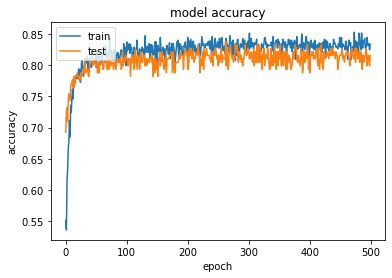

In [17]:
plot_model_history(history)

In [18]:
def draw_confusion_matrix(evaluation_result, label):
    # TP FP
    # FN TN
    matrix = np.round(np.array([[evaluation_result[1], evaluation_result[2]], [evaluation_result[4], evaluation_result[3]]]))
    
    plt.figure(figsize=(4,3))
    
    ax = sns.heatmap(data=matrix, annot=True, fmt=".0f")
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Confusion matrix for {label}")

Train evaluation:
712/712 - 1s - loss: 0.4433 - tp: 202.0000 - fp: 44.0000 - tn: 400.0000 - fn: 66.0000 - accuracy: 0.8455 - precision: 0.8211 - recall: 0.7537 - auc: 0.8808


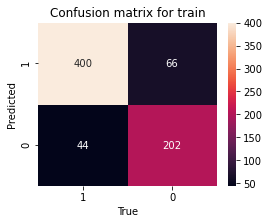

In [19]:
print("Train evaluation:")
evaluation_train = model.evaluate(X_train, Y_train, verbose=2)
draw_confusion_matrix(evaluation_train, "train")

Dev evaluation:
179/179 - 0s - loss: 0.4803 - tp: 56.0000 - fp: 15.0000 - tn: 90.0000 - fn: 18.0000 - accuracy: 0.8156 - precision: 0.7887 - recall: 0.7568 - auc: 0.8956


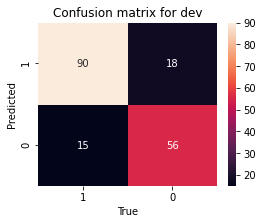

In [20]:
print("Dev evaluation:")
evaluation_dev = model.evaluate(X_dev, Y_dev, verbose=2)
draw_confusion_matrix(evaluation_dev, "dev")

# Predict with DL model

In [21]:
def store_predictions(model, submission_name):
    predictions = model.predict(X_test)

    predictions = np.round(predictions).astype(np.uint8).reshape((-1))

    print(f"{submission_name}:\n{predictions}")
    
    output = pd.DataFrame({"Survived": predictions}, index=test_data.index)
    output.to_csv(f"{submission_name}.csv", index=True)

In [22]:
store_predictions(model, "dl_submission")

dl_submission:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 1 0 1 0 0 1]


# Tune hyperparameters for the DL model

In [23]:
import kerastuner as kt

# https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner
# https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/

class TitanicHyperModel(kt.HyperModel):
    def __init__(self, input_size):
        self.input_shape = (input_size, )

    def build(self, hp):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, InputLayer
        from tensorflow.keras.regularizers import L1L2

        model = Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        
        for layer_n in range(hp.Int("num_layers", min_value=2, max_value=7, step=1, default=3)):
            units = hp.Int(
                f"dense_units_{layer_n}",
                min_value=8,
                max_value=64,
                step=8,
                default=64
            )
            activation = hp.Choice(
                f"dense_activation_{layer_n}",
                values=["relu", "tanh"],
                default="relu"
            )
            regularizer_l1 = hp.Choice(
                f"l1_{layer_n}",
                values=[0.01, 0.001, 1e-4, 1e-5, 0.0],
                default=1e-2
            )
            regularizer_l2 = hp.Choice(
                f"l2_{layer_n}",
                values=[0.1, 0.01, 0.001],
                default=1e-2
            )
            initializer = "he_uniform" if activation == "relu" else "glorot_uniform"

            model.add(Dense(
                units=units,
                activation=activation,
                kernel_regularizer=L1L2(l1=regularizer_l1, l2=regularizer_l2),
                bias_regularizer=L1L2(l1=regularizer_l1, l2=regularizer_l2),
                kernel_initializer=initializer
            ))
            
            droupout_rate = hp.Float(
                f"dropout_{layer_n}",
                min_value=0.15,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )
            
            model.add(Dropout(rate=droupout_rate))
        
        model.add(Dense(1, activation="sigmoid"))
        
        learning_rate = hp.Choice(
            "learning_rate",
            values=[1e-2, 1e-3],#, 5e-4, 1e-4],
            default=1e-3
        )
        
        optimizer = hp.Choice(
            "optimizer",
            values=["adam", "RMSprop"],
            default="adam"
        )
        optimizer_type = {
            "adam": keras.optimizers.Adam,
            "RMSprop": keras.optimizers.RMSprop,
            "SGD": keras.optimizers.SGD
        }
        
        model.compile(
            optimizer=optimizer_type[optimizer](learning_rate=learning_rate),
            metrics=METRICS,
            loss="binary_crossentropy",
        )

        return model

hypermodel = TitanicHyperModel(input_size=X_train.shape[1])

In [24]:
class MyTuner(kt.Tuner):
    def run_trial(self, trial, X_train, Y_train, validation_data):
        hp = trial.hyperparameters
        
        batch_size = hp.Int("batch_size", 16, 128, step=16, default=32)
        epoch_number = hp.Int("epoch_number", 400, 700, step=100, default=500)
        
        model = self.hypermodel.build(hp)
        
        history = model.fit(X_train, Y_train, epochs=epoch_number, batch_size=batch_size, validation_data=validation_data, class_weight=class_weights)
        
        self.oracle.update_trial(trial.trial_id, {"val_accuracy": history.history["val_accuracy"][-1]})
        self.save_model(trial.trial_id, model)
        

In [25]:
# Dev mode

if MODE == "DEV":
    MAX_TRIALS = 20
else:
    MAX_TRIALS = 200

In [26]:
try:
    ATTEMPT = ATTEMPT + 1
except NameError:
    ATTEMPT = 0

hp = kt.HyperParameters()
if MODE == "DEV":
    hp.Fixed("epoch_number", 50)
# else:
#     hp.Fixed("epoch_number", 500)

# Seems like 32 always comes to be the best option...
hp.Fixed("batch_size", 32)

tuner = MyTuner(
    oracle=kt.oracles.RandomSearch(
        objective="val_accuracy",
        seed=SEED,
        hyperparameters=hp,
        tune_new_entries=True,
        max_trials=MAX_TRIALS),
    hypermodel=hypermodel,
    directory=f"my_search_{ATTEMPT}",
    project_name="titanic"
)

# tuner.search_space_summary()

In [27]:
tuner.search(X_train, Y_train, validation_data=(X_dev, Y_dev))

# tuner.results_summary()

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 4s 6ms/sample - loss: 1.3829 - tp: 169.0000 - fp: 137.0000 - tn: 307.0000 - fn: 99.0000 - accuracy: 0.6685 - precision: 0.5523 - recall: 0.6306 - auc: 0.7077 - val_loss: 0.9195 - val_tp: 61.0000 - val_fp: 32.0000 - val_tn: 73.0000 - val_fn: 13.0000 - val_accuracy: 0.7486 - val_precision: 0.6559 - val_recall: 0.8243 - val_auc: 0.8671
Epoch 2/500
712/712 [==============================] - 0s 209us/sample - loss: 0.8558 - tp: 195.0000 - fp: 104.0000 - tn: 340.0000 - fn: 73.0000 - accuracy: 0.7514 - precision: 0.6522 - recall: 0.7276 - auc: 0.8152 - val_loss: 0.8045 - val_tp: 38.0000 - val_fp: 5.0000 - val_tn: 100.0000 - val_fn: 36.0000 - val_accuracy: 0.7709 - val_precision: 0.8837 - val_recall: 0.5135 - val_auc: 0.8706
Epoch 3/500
712/712 [==============================] - 0s 224us/sample - loss: 0.7469 - tp: 188.0000 - fp: 89.0000 - tn: 355.0000 - fn: 80.0000 - accuracy: 0.7626 - precisi

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 4s 6ms/sample - loss: 21.9445 - tp: 173.0000 - fp: 276.0000 - tn: 168.0000 - fn: 95.0000 - accuracy: 0.4789 - precision: 0.3853 - recall: 0.6455 - auc: 0.5438 - val_loss: 9.7069 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 102.0000 - val_fn: 62.0000 - val_accuracy: 0.6369 - val_precision: 0.8000 - val_recall: 0.1622 - val_auc: 0.6679
Epoch 2/500
712/712 [==============================] - 0s 193us/sample - loss: 5.4842 - tp: 93.0000 - fp: 132.0000 - tn: 312.0000 - fn: 175.0000 - accuracy: 0.5688 - precision: 0.4133 - recall: 0.3470 - auc: 0.4979 - val_loss: 2.5780 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 105.0000 - val_fn: 74.0000 - val_accuracy: 0.5866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/500
712/712 [==============================] - 0s 194us/sample - loss: 1.7452 - tp: 4.0000 - fp: 15.0000 - tn: 429.0000 - fn: 264.0000 - accuracy: 0

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 4s 6ms/sample - loss: 5.2219 - tp: 109.0000 - fp: 159.0000 - tn: 285.0000 - fn: 159.0000 - accuracy: 0.5534 - precision: 0.4067 - recall: 0.4067 - auc: 0.5496 - val_loss: 2.5248 - val_tp: 35.0000 - val_fp: 13.0000 - val_tn: 92.0000 - val_fn: 39.0000 - val_accuracy: 0.7095 - val_precision: 0.7292 - val_recall: 0.4730 - val_auc: 0.8295
Epoch 2/500
712/712 [==============================] - 0s 174us/sample - loss: 1.8127 - tp: 118.0000 - fp: 126.0000 - tn: 318.0000 - fn: 150.0000 - accuracy: 0.6124 - precision: 0.4836 - recall: 0.4403 - auc: 0.5948 - val_loss: 1.2434 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 105.0000 - val_fn: 74.0000 - val_accuracy: 0.5866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7687
Epoch 3/500
712/712 [==============================] - 0s 174us/sample - loss: 0.9827 - tp: 11.0000 - fp: 4.0000 - tn: 440.0000 - fn: 257.0000 - accuracy: 

Train on 712 samples, validate on 179 samples
Epoch 1/600
712/712 [==============================] - 3s 5ms/sample - loss: 4.8712 - tp: 117.0000 - fp: 173.0000 - tn: 271.0000 - fn: 151.0000 - accuracy: 0.5449 - precision: 0.4034 - recall: 0.4366 - auc: 0.5141 - val_loss: 1.4556 - val_tp: 38.0000 - val_fp: 18.0000 - val_tn: 87.0000 - val_fn: 36.0000 - val_accuracy: 0.6983 - val_precision: 0.6786 - val_recall: 0.5135 - val_auc: 0.8125
Epoch 2/600
712/712 [==============================] - 0s 149us/sample - loss: 1.0572 - tp: 131.0000 - fp: 128.0000 - tn: 316.0000 - fn: 137.0000 - accuracy: 0.6278 - precision: 0.5058 - recall: 0.4888 - auc: 0.6600 - val_loss: 0.9131 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 105.0000 - val_fn: 74.0000 - val_accuracy: 0.5866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8382
Epoch 3/600
712/712 [==============================] - 0s 148us/sample - loss: 0.8655 - tp: 94.0000 - fp: 137.0000 - tn: 307.0000 - fn: 174.0000 - accuracy

# Results of the tuning

In [28]:
NUM_TOP_MODELS = min(10, MAX_TRIALS)

top_models = tuner.get_best_models(num_models=NUM_TOP_MODELS)
top_hyperparameters = tuner.get_best_hyperparameters(num_trials=NUM_TOP_MODELS)

for exp_id in range(NUM_TOP_MODELS):
    print(f"\n\nTuned model {exp_id}\n\n")
    cur_model = top_models[exp_id]
    
    print("Tuned train:")
    evaluation_tuned_train = cur_model.evaluate(X_train, Y_train)
    # draw_confusion_matrix(evaluation_tuned_train, f"tuned train {exp_id}")

    print("Tuned dev:")
    evaluation_tuned_dev = cur_model.evaluate(X_dev, Y_dev)
    # draw_confusion_matrix(evaluation_tuned_dev, f"tuned dev {exp_id}")

    print("Model summary")
    cur_model.summary()
    
    print("Hyperparameters")
    print(top_hyperparameters[exp_id].values)



Tuned model 0


Tuned train:
712/712 [==============================] - 1s 1ms/sample - loss: 0.4399 - tp: 208.0000 - fp: 58.0000 - tn: 386.0000 - fn: 60.0000 - accuracy: 0.8343 - precision: 0.7820 - recall: 0.7761 - auc: 0.8806
Tuned dev:
179/179 [==============================] - 0s 111us/sample - loss: 0.4701 - tp: 61.0000 - fp: 16.0000 - tn: 89.0000 - fn: 13.0000 - accuracy: 0.8380 - precision: 0.7922 - recall: 0.8243 - auc: 0.8954
Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                816       
______________________________________________________________

# Predict with the Tuned model

In [29]:
for exp_id in range(NUM_TOP_MODELS):
    store_predictions(top_models[exp_id], f"dl_tuned_{exp_id}_submission")

dl_tuned_0_submission:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 1]
dl_tuned_1_submission:
[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0